In [2]:
from getpass import getpass
token = getpass('GitHub token: ')

GitHub token: ··········


In [3]:
!git clone --branch main https://$token@github.com/Bartekb3/fromscratch-transformer-classifier.git

Cloning into 'fromscratch-transformer-classifier'...
remote: Enumerating objects: 1391, done.
remote: Counting objects: 100% (385/385), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 1391 (delta 206), reused 271 (delta 144), pack-reused 1006 (from 1)
Receiving objects: 100% (1391/1391), 20.87 MiB | 37.42 MiB/s, done.
Resolving deltas: 100% (704/704), done.


In [4]:
%cd /content/fromscratch-transformer-classifier

/content/fromscratch-transformer-classifier


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!cp /content/drive/MyDrive/data/raw/articles-training-bypublisher-20181122.xml /content/fromscratch-transformer-classifier/data/raw/articles-training-bypublisher-20181122.xml
!cp /content/drive/MyDrive/data/raw/articles-validation-bypublisher-20181122.xml /content/fromscratch-transformer-classifier/data/raw/articles-validation-bypublisher-20181122.xml
!cp /content/drive/MyDrive/data/raw/ground-truth-training-bypublisher-20181122.xml /content/fromscratch-transformer-classifier/data/raw/ground-truth-training-bypublisher-20181122.xml
!cp /content/drive/MyDrive/data/raw/ground-truth-validation-bypublisher-20181122.xml /content/fromscratch-transformer-classifier/data/raw/ground-truth-validation-bypublisher-20181122.xml

In [8]:
import xml.etree.ElementTree as ET
import re
import sys
from pathlib import Path
import pandas as pd
import torch
from sklearn.model_selection import train_test_split


In [10]:
from src.textclf_transformer import *

In [16]:
XML_FILE_PATH_TRAIN = './data/raw/articles-training-bypublisher-20181122.xml'
CLASSES_XML_PATH_TRAIN = './data/raw/ground-truth-training-bypublisher-20181122.xml'

XML_FILE_PATH_VALIDATION = './data/raw/articles-validation-bypublisher-20181122.xml'
CLASSES_XML_PATH_VALIDATION = './data/raw/ground-truth-validation-bypublisher-20181122.xml'
RECORD_TAG_NAME = 'article'
PARAGRAPH_TAG_NAME = 'p'
MIN_TEXT_LENGTH = 7000
OUTPUT_CSV_PATH_TRAIN = './data/raw/hyperpartisan_articles_train.csv'
OUTPUT_CSV_PATH_VALIDATION = './data/raw/hyperpartisan_articles_validation.csv'
RECORD_TAG_NAME = 'article'

In [ ]:
import pandas as pd

def downsample_majority(df, seed=42):
    """
    Funkcja zmniejsza liczbę wierszy klasy większościowej do liczby wierszy klasy mniejszościowej,
    tak aby uzyskać balans 50/50.

    Parametry:
    - df: pandas DataFrame z kolumnami 'text' i 'class' (0 i 1)
    - seed: int, seed do losowego wyboru wierszy

    Zwraca:
    - zbalansowany DataFrame
    """
    df_0 = df[df['class'] == 0]
    df_1 = df[df['class'] == 1]

    if len(df_0) > len(df_1):
        majority = df_0
        minority = df_1
    else:
        majority = df_1
        minority = df_0

    majority_downsampled = majority.sample(n=len(minority), random_state=seed)

    df_balanced = pd.concat([minority, majority_downsampled]).sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_balanced


def resize_balanced(df, target_size, seed=42):
    """
    Funkcja losowo zmniejsza zbalansowany DataFrame do docelowego rozmiaru,
    zachowując 50/50 dla klas 0 i 1.

    Parametry:
    - df: pandas DataFrame z kolumnami 'text' i 'class' (0 i 1), już zbalansowany
    - target_size: int, docelowa liczba wierszy (musi być podzielna przez 2)
    - seed: int, seed do losowego wyboru wierszy

    Zwraca:
    - zbalansowany DataFrame o podanym rozmiarze
    """
    assert target_size % 2 == 0, "target_size musi być podzielny przez 2"

    half_size = target_size // 2
    df_0 = df[df['class'] == 0].sample(n=half_size, random_state=seed)
    df_1 = df[df['class'] == 1].sample(n=half_size, random_state=seed)

    df_resized = pd.concat([df_0, df_1]).sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_resized


In [ ]:
def convert_xml_to_csv_streamed(xml_path, csv_path, record_tag, paragraph_tag, min_length):
    """
    Streams through a large XML file, extracts article data (ID and concatenated
    text from paragraph tags), filters records based on minimum text length,
    and writes the results to a CSV file.

    This function uses xml.etree.ElementTree.iterparse for memory-efficient
    processing of large files.

    Args:
        xml_path (str): Path to the input XML file.
        csv_path (str): Path to the output CSV file.
        record_tag (str): The name of the XML tag representing a single record (e.g., 'article').
        paragraph_tag (str): The name of the XML tag containing the text segments (e.g., 'p').
        min_length (int): The minimum required length of the concatenated article text
                          for the record to be saved to CSV.
    """

    total_records_count = 0
    saved_records_count = 0

    print(f"Starting XML parsing: {xml_path}")
    print(f"   Minimum text length filter: {min_length} characters.")

    try:
        with open(csv_path, 'w', newline='', encoding='utf-8') as outfile:

            fieldnames = ['article_id', 'text', 'class']
            writer = csv.DictWriter(outfile, fieldnames=fieldnames)
            writer.writeheader()

            context = ET.iterparse(xml_path, events=('end',))

            for event, record_element in context:


                clean_tag = re.sub(r'\{.*?\}', '', record_element.tag)

                if clean_tag == record_tag:
                    total_records_count += 1

                    article_id = record_element.attrib.get('id', '')

                    article_text_segments = []

                    for child in record_element:
                        child_clean_tag = re.sub(r'\{.*?\}', '', child.tag)

                        if child_clean_tag == paragraph_tag and child.text:
                            article_text_segments.append(child.text.strip())

                    final_text = " ".join(article_text_segments)

                    if len(final_text) >= min_length:

                        writer.writerow({
                            'article_id': article_id,
                            'text': final_text,
                            'class': ''
                        })
                        saved_records_count += 1

                    record_element.clear()

        print(f"\nConversion completed successfully! Data saved to '{csv_path}'")
        print(f"   Total records parsed: {total_records_count}")
        print(f"   Records saved (length >= {min_length}): {saved_records_count}")
        print(f"   Records rejected: {total_records_count - saved_records_count}")

    except FileNotFoundError:
        print(f"Error: File not found at '{xml_path}'. Please check the path.")
    except Exception as e:
        print(f"An error occurred during processing: {e}")



def add_classes_to_csv(xml_path_classes, csv_path_articles, csv_path_output, record_tag):
    """
    Reads an XML file containing ground truth classes (hyperpartisan labels)
    and merges this information into an existing CSV file containing article texts.

    The process is:
    1. Stream-parse the XML file to create an Article ID -> Class mapping.
    2. Load the CSV file into a pandas DataFrame.
    3. Apply the class map to the 'class' column of the DataFrame based on 'article_id'.
    4. Save the resulting DataFrame to the output CSV file.

    Args:
        xml_path_classes (str): Path to the XML file with class labels (ground truth).
        csv_path_articles (str): Path to the input CSV file containing articles (ID and text).
        csv_path_output (str): Path to the output CSV file where classes will be added.
        record_tag (str): The XML tag name representing a single record (e.g., 'article').
    """

    print(f"Step 1: Parsing classes file ({os.path.basename(xml_path_classes)})...")

    classes_map = {}
    counter = 0

    try:

        context = ET.iterparse(xml_path_classes, events=('end',))

        for event, record_element in context:

            clean_tag = re.sub(r'\{.*?\}', '', record_element.tag)

            if clean_tag == record_tag:
                article_id = record_element.attrib.get('id')

                class_label = record_element.attrib.get('hyperpartisan')

                if article_id and class_label is not None:
                    classes_map[article_id] = class_label
                    counter += 1

                record_element.clear()

        print(f" Parsing finished. Identified {counter} class labels.")

        if not classes_map:
            print(" Warning: No classes found in the XML file. Merge operation cancelled.")
            return


        print(f" Step 2: Loading articles CSV ({os.path.basename(csv_path_articles)})...")

        df_articles = pd.read_csv(csv_path_articles, dtype={'article_id': str})


        df_articles['class'] = df_articles['article_id'].map(classes_map)


        df_articles['class'] = df_articles['class'].fillna('')


        print(f" Step 3: Saving final CSV file to: {os.path.basename(csv_path_output)}")
        df_articles.to_csv(csv_path_output, index=False, encoding='utf-8')

        print(f" Success! File '{csv_path_output}' is ready with the populated 'class' column.")

    except FileNotFoundError as e:
        print(f" Error: File not found: {e.filename}")
    except Exception as e:
        print(f" An error occurred during data processing: {e}")


In [17]:
convert_xml_to_csv_streamed(XML_FILE_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, RECORD_TAG_NAME, PARAGRAPH_TAG_NAME, MIN_TEXT_LENGTH)
add_classes_to_csv(CLASSES_XML_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, OUTPUT_CSV_PATH_TRAIN, RECORD_TAG_NAME)
convert_xml_to_csv_streamed(XML_FILE_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, RECORD_TAG_NAME, PARAGRAPH_TAG_NAME, MIN_TEXT_LENGTH)
add_classes_to_csv(CLASSES_XML_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, OUTPUT_CSV_PATH_VALIDATION, RECORD_TAG_NAME)

🔄 Starting XML parsing: ./data/raw/articles-training-bypublisher-20181122.xml
   Minimum text length filter: 7000 characters.

✅ Conversion completed successfully! Data saved to './data/raw/hyperpartisan_articles_train.csv'
   Total records parsed: 600000
   Records saved (length >= 7000): 58765
   Records rejected: 541235
🔄 Step 1: Parsing classes file (ground-truth-training-bypublisher-20181122.xml)...
   ✅ Parsing finished. Identified 600000 class labels.
🔄 Step 2: Loading articles CSV (hyperpartisan_articles_train.csv)...
🔄 Step 3: Saving final CSV file to: hyperpartisan_articles_train.csv
✅ Success! File './data/raw/hyperpartisan_articles_train.csv' is ready with the populated 'class' column.
🔄 Starting XML parsing: ./data/raw/articles-validation-bypublisher-20181122.xml
   Minimum text length filter: 7000 characters.

✅ Conversion completed successfully! Data saved to './data/raw/hyperpartisan_articles_validation.csv'
   Total records parsed: 150000
   Records saved (length >= 70

In [18]:
val_df = pd.read_csv(OUTPUT_CSV_PATH_VALIDATION)

In [46]:
val_df.groupby('class').count()

,article_id,text
class,,
0,3250,3250
1,3250,3250


In [24]:
val_df = downsample_majority(val_df)
val_df = resize_balanced(val_df, 13000)

In [45]:
val_df['class'] = val_df['class'].map({True: 1, False: 0})


In [25]:
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['class'])

In [51]:
val_df.to_csv('./data/raw/hyperpartisan_articles_validation.csv', index=False)
test_df.to_csv('./data/raw/hyperpartisan_articles_test.csv', index=False)


In [26]:
tok = WordPieceTokenizerWrapper()
tok.load(tokenizer_dir=r"./src/textclf_transformer/tokenizer/BERT_original")
save_dir = Path("./data/tokenized/")
save_dir.mkdir(parents=True, exist_ok=True)

In [32]:
tokens_test = tok.encode_pandas(test_df, 'text',
                                  max_length=4096,
                                  label_col='class'
                                 )
tokens_val = tok.encode_pandas(val_df, 'text',
                                  max_length=4096,
                                  label_col='class'
                                 )

In [33]:
print(tok.tokenizer.decode(tokens_val[0][0]))

[CLS] more on : one of my usual laugh lines is that the cic isn ’ t a sovereign wealth fund ; it is a sovereign loss - minimization fund. after all, selling debt denominated in an appreciating currency ( and one that, given china ’ s current account surplus, should face ongoing pressure to appreciate ) to buy assets denominated in a depreciating currency is generally a good way to lose money. all the more so if the interest rate on the appreciating currency is higher than the interest rate on the depreciating currency. the pboc has long faced the same problem. consequently, china ’ s policy of holding the rmb down to support its exports produced highly front - loaded benefits ( fast export growth, jobs in the export sector ) and highly back - loaded costs ( the bill for the losses on all the dollars and euros the central bank has had to buy to keep china ’ s currency from appreciating ). the benefits are now shrinking - - chinese export growth to the us has stalled - - while the costs 

In [34]:
c = 0
for i in range(len(tokens_val)):
    c += tokens_val[i][2]
c/len(tokens_val)

tensor(0.5000)

In [35]:

nonzero_count = []
for i in range(len(tokens_val)):
    tensor_sequence = torch.tensor(tokens_val[i][0])
    count = tensor_sequence.nonzero().shape[0]
    nonzero_count.append(count)


/tmp/ipython-input-867311444.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_sequence = torch.tensor(tokens_val[i][0])


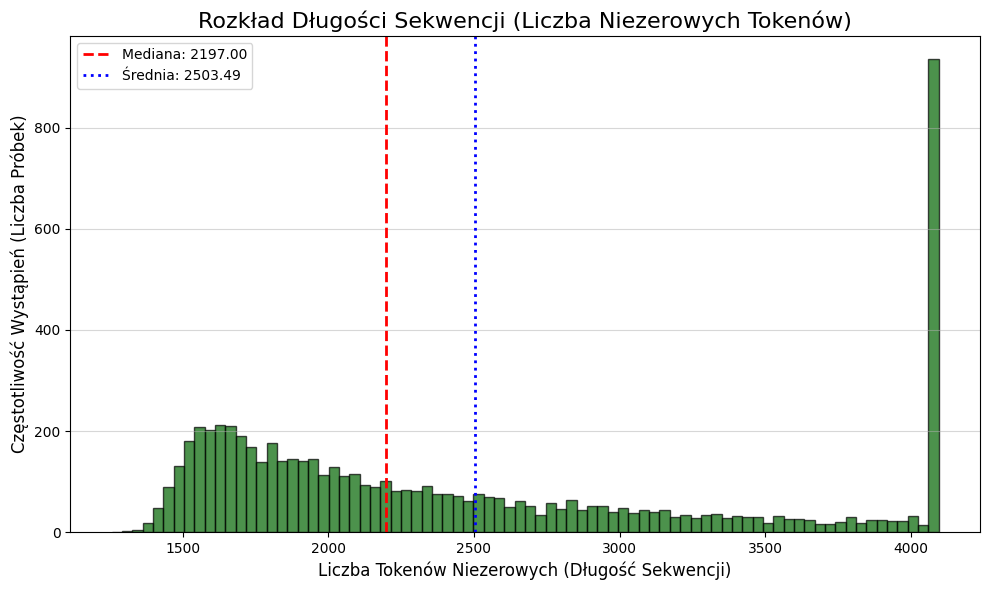

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def generate_length_histogram(counts_list):
    """
    Generuje i wyświetla histogram rozkładu długości sekwencji (liczby niezerowych tokenów).

    Args:
        counts_list (list/np.ndarray): Lista zawierająca liczbę niezerowych tokenów
                                       dla każdej próbki.
    """
    if not counts_list:
        print("Błąd: Lista nonzero_count jest pusta. Nie można wygenerować histogramu.")
        return

    data = np.array(counts_list)

    bins = int(np.sqrt(len(data))) if len(data) > 30 else 10

    plt.figure(figsize=(10, 6))


    plt.hist(data, bins=bins, color='darkgreen', edgecolor='black', alpha=0.7)

    median_val = np.median(data)
    mean_val = np.mean(data)

    plt.axvline(median_val, color='red', linestyle='dashed', linewidth=2, label=f'Mediana: {median_val:.2f}')
    plt.axvline(mean_val, color='blue', linestyle='dotted', linewidth=2, label=f'Średnia: {mean_val:.2f}')

    plt.title('Rozkład Długości Sekwencji (Liczba Niezerowych Tokenów)', fontsize=16)
    plt.xlabel('Liczba Tokenów Niezerowych (Długość Sekwencji)', fontsize=12)
    plt.ylabel('Częstotliwość Wystąpień (Liczba Próbek)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()


generate_length_histogram(nonzero_count)

In [37]:
torch.save(tokens_val, save_dir / "hyperpartisan_val.pt")
torch.save(tokens_test, save_dir / "hyperpartisan_test.pt")

In [ ]:
del val_df
del test_df
del tokens_val
del tokens_test

In [38]:
train_df = pd.read_csv(OUTPUT_CSV_PATH_TRAIN)

In [40]:
train_df = downsample_majority(train_df)
train_df = resize_balanced(train_df, 52000)

In [41]:
train_df.groupby('class').count()

,article_id,text
class,,
False,26000,26000
True,26000,26000


In [43]:
train_df['class'] = train_df['class'].map({True: 1, False: 0})


In [44]:
train_df.head()

,article_id,text,class
0,1483477,"Wednesday, August 30, is Warren Buffett's 87th...",1
1,46436,"DUBAI, United Arab Emirates (AP) - As protests...",0
2,1353319,"MECHANICSVILLE, Va. — Baptists must acknowledg...",0
3,695223,.......... .......... .......... .......... .....,0
4,1201614,"One Monday in June 2009, at the start of the e...",1


In [47]:
tokens_train = tok.encode_pandas(train_df, 'text',
                                  max_length=4096,
                                    label_col='class')

In [48]:
torch.save(tokens_train, save_dir / "hyperpartisan_train.pt")

In [49]:
!cp ./data/tokenized/hyperpartisan_train.pt /content/drive/MyDrive/data/tokenized/hyperpartisan_train.pt
!cp ./data/tokenized/hyperpartisan_val.pt /content/drive/MyDrive/data/tokenized/hyperpartisan_val.pt
!cp ./data/tokenized/hyperpartisan_test.pt /content/drive/MyDrive/data/tokenized/hyperpartisan_test.pt

In [54]:
!cp ./data/raw/hyperpartisan_articles_train.csv /content/drive/MyDrive/data/raw/hyperpartisan_articles_train.csv
!cp ./data/raw/hyperpartisan_articles_validation.csv /content/drive/MyDrive/data/raw/hyperpartisan_articles_validation.csv
!cp ./data/raw/hyperpartisan_articles_test.csv /content/drive/MyDrive/data/raw/hyperpartisan_articles_test.csv